In [59]:
%load_ext autoreload
%autoreload 2

In [5]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, random_split
import torch.nn.functional as F
import sys
import numpy as np
np.random.seed(42)
import os
import pickle
import pandas as pd
parent_dir = os.path.abspath("../../")
sys.path.append(parent_dir)
parent_dir = os.path.abspath("../../utils/")
sys.path.append(parent_dir)

## Analysis

$\phi(\boldsymbol{u})$ is a random feature map for $\boldsymbol{u} \in \mathbb{R}^d$. For $\boldsymbol{Q'}, \boldsymbol{K'} \in \mathbb{R}^{L \times r}$ with rows given as  $\phi(\boldsymbol{q_i}^T)^T$ and $\phi(\boldsymbol{k_i}^T)^T$ respectively, leads to the more efficient attention mechanism of the form:
 $$
\begin{aligned}
  &\mathrm{Att}_{\!\leftrightarrow}(\mathbf{Q},\mathbf{K},\mathbf{V})
   = \hat{\mathbf{D}}^{-1}\bigl(\mathbf{Q}'((\mathbf{K}')^{\!\top}\mathbf{V})\bigr),
  &
  &\hat{\mathbf{D}}
   = \operatorname{diag}\!\bigl(\mathbf{Q}'((\mathbf{K}')^{\!\top}\mathbf{1}_L)\bigr).
\end{aligned}
$$

In the paper, they choose: 
$$\phi(\mathbf{x}) = \frac{h(\mathbf{x})}{\sqrt{m}} \left(f_1(\omega_1^T \mathbf{x}), \dots, f_1(\omega_m^T \mathbf{x}), ..., f_l(\omega_1^T \mathbf{x}), ..., f_l(\omega_m^T \mathbf{x})\right)$$

Here are 3 possible combinations to try:
1. $$\hat{SM_{m}}^{trig} (\mathbf{x}, \mathbf{y}) := h(x) = exp\left(\frac{\|\mathbf{x}\|^2}{2}\right), l=2, f_1 = sin, f_2 = cos$$
2. $$\hat{SM_{m}}^{+} (\mathbf{x}, \mathbf{y}) := h(x) = exp\left(-\frac{\|\mathbf{x}\|^2}{2}\right), l=1, f_1 = exp$$
3. $$\hat{SM_{m}}^{hyp+} (\mathbf{x}, \mathbf{y}) := h(x) = \frac{1}{\sqrt{2}}exp\left(-\frac{\|\mathbf{x}\|^2}{2}\right), l=2, f_1 = exp(u), f_2 = exp(-u)$$


How to choose $w_i$'s such that it is orthogonal:
We want to choose different random samples $\omega_1,...,\omega_m$ such that they come from $D \sim \mathcal{N}(0, \mathbf{I_d})$. We can use the Gram-Schmidt orthogonalisation to generate these. 


In [6]:
def gram_schmidt(vectors):
    """
    Apply Gram-Schmidt orthogonalization to a set of vectors.
    
    Args:
        vectors: numpy array of shape (m, n) where m is number of vectors
                and n is the dimension of each vector
    
    Returns:
        orthogonal_vectors: numpy array of orthogonalized vectors
    """
    vectors = vectors.copy().astype(float)
    m, n = vectors.shape
    
    for i in range(m):
        vectors[i] = vectors[i] / np.linalg.norm(vectors[i])
        for j in range(i + 1, m):
            projection = np.dot(vectors[j], vectors[i]) * vectors[i]
            vectors[j] = vectors[j] - projection
    
    return vectors

def generate_random_vectors_gaussian(m, n, mean=0, std=1):
    """Generate m random vectors from Gaussian distribution."""
    return np.random.normal(mean, std, (m, n))

def generate_random_vectors_uniform(m, n, low=-1, high=1):
    """Generate m random vectors from uniform distribution."""
    return np.random.uniform(low, high, (m, n))

def generate_random_vectors_multivariate_normal(m, n, mean=None, cov=None):
    """Generate m random vectors from multivariate normal distribution."""
    if mean is None:
        mean = np.zeros(n)
    if cov is None:
        cov = np.eye(n)
    
    return np.random.multivariate_normal(mean, cov, m)

def generate_orthogonal_random_vectors(m, n, distribution='gaussian', **kwargs):
    """
    Generate m orthogonal random vectors of dimension n.
    
    Args:
        m: number of vectors
        n: dimension of each vector
        distribution: 'gaussian', 'uniform', or 'multivariate_normal'
        **kwargs: additional parameters for distribution
    
    Returns:
        orthogonal_vectors: numpy array of orthogonalized random vectors
    """
    if m > n:
        raise ValueError(f"Cannot generate {m} orthogonal vectors in {n}D space")
    
    if distribution == 'gaussian':
        vectors = generate_random_vectors_gaussian(m, n, **kwargs)
    elif distribution == 'uniform':
        vectors = generate_random_vectors_uniform(m, n, **kwargs)
    elif distribution == 'multivariate_normal':
        vectors = generate_random_vectors_multivariate_normal(m, n, **kwargs)
    else:
        raise ValueError("Distribution must be 'gaussian', 'uniform', or 'multivariate_normal'")
    
    return gram_schmidt(vectors)

In [57]:
def random_feature_map(omegas, x, kernel_type="trig"):
    if kernel_type == "trig":
        num = np.exp(np.linalg.norm(x)**2 / 2) / np.sqrt(omegas.shape[0])
        ws =  omegas @ x
        f1, f2 = np.sin(ws), np.cos(ws)
        return num * np.concatenate([f1, f2])
    elif kernel_type == "+":
        num = np.exp(-np.linalg.norm(x)**2 / 2) / np.sqrt(omegas.shape[0])
        ws = omegas @ x
        f1 = np.exp(ws)
        return num * f1
    elif kernel_type == "hyp":
        num = np.exp(-np.linalg.norm(x)**2 / 2) / np.sqrt(2 * omegas.shape[0])
        ws = omegas @ x
        f1, f2 = np.exp(ws), np.exp(-ws)
        return num * np.concatenate([f1, f2])
    else:
        raise ValueError(f"Unknown kernel type: {kernel_type}")
    
# --- Random Feature Map Function (PyTorch version) ---
def random_feature_map_torch(omegas_t, x_t, kernel_type="+"):
    """
    Computes random features for positive kernel, vectorized for PyTorch.

    Args:
        omegas_t (torch.Tensor): Random projection matrix (m, d).
        x_t (torch.Tensor): Input tensor (L, d).
        kernel_type (str): Specifies the kernel type. Currently only "+" is implemented.

    Returns:
        torch.Tensor: Random features (L, m).
    """
    if kernel_type == "+":
        norm_sq = torch.sum(x_t**2, dim=-1, keepdim=True)

        # Apply scaling to omegas for numerical stability (1/sqrt(2))
        ws = x_t @ (omegas_t.T / torch.sqrt(torch.tensor(2.0, device=x_t.device)))
        f1 = torch.exp(ws)
        num_term = torch.exp(-norm_sq / 2) / torch.sqrt(torch.tensor(omegas_t.shape[0], dtype=torch.float32, device=x_t.device))

        return num_term * f1
    elif kernel_type == "trig":
        norm_sq = torch.sum(x_t**2, dim=-1, keepdim=True)
        ws = x_t @ (omegas_t.T / torch.sqrt(torch.tensor(2.0, device=x_t.device)))
        f1, f2 = torch.sin(ws), torch.cos(ws)
        num_term = torch.exp(norm_sq / 2) /torch.sqrt(torch.tensor(omegas_t.shape[0], dtype=torch.float32, device=x_t.device))
        return num_term * torch.cat([f1, f2], dim=-1)
    elif kernel_type == "hyp":
        norm_sq = torch.sum(x_t**2, dim=-1, keepdim=True)
        ws = x_t @ (omegas_t.T / torch.sqrt(torch.tensor(2.0, device=x_t.device)))
        f1, f2 = torch.exp(ws), torch.exp(-ws)
        num_term = torch.exp(-norm_sq / 2) / torch.sqrt(torch.tensor(2.0 * omegas_t.shape[0], dtype=torch.float32, device=x_t.device))
        return num_term * torch.cat([f1, f2], dim=-1)
    else:
        raise NotImplementedError(f"Kernel type '{kernel_type}' is not implemented for PyTorch conversion.")

    
def iid_gaussian_torch(rows, cols, device):
    return torch.randn(rows, cols, device=device)

def orthogonal_gaussian_torch(m, d, device):
    """
    Generates a matrix composed of stacked orthogonal blocks.
    
    Args:
        m (int): The desired number of rows (vectors).
        d (int): The dimension of each vector.
        device (torch.device): The device (e.g., 'cpu' or 'cuda') to place the tensors on.

    Returns:
        torch.Tensor: A tensor of shape (m, d) where blocks of d rows are orthogonal.
    """
    def orthogonal_square():
        q, _ = torch.linalg.qr(iid_gaussian_torch(d, d, device))
        return q.T

    num_squares = int(m / d)
    blocks = [orthogonal_square() for _ in range(num_squares)]

    remainder = m - d * num_squares
    if remainder > 0:
        blocks.append(orthogonal_square()[:remainder])
    matrix = torch.cat(blocks, dim=0)
    divisor = torch.sqrt(torch.tensor(float(num_squares) + float(remainder) / d, device=device))
    matrix /= divisor

    return matrix

def my_favour(query, key, value, m_omegas, omegas, kernel_type="trig"):
    _, L, d = query.shape
    query_norm = query / (d ** 0.25)
    key_norm = key / (d ** 0.25)

    if kernel_type == "trig" or kernel_type == "hyp":
        feature_dimension = 2 * m_omegas
    else: # For kernel_type == "+"
        feature_dimension = m_omegas

    new_query = np.zeros((L, feature_dimension))
    new_key = np.zeros((L, feature_dimension))

    for i in range(L):
        new_query[i] = random_feature_map(omegas, query_norm[i], kernel_type=kernel_type)
        new_key[i] = random_feature_map(omegas, key_norm[i], kernel_type=kernel_type)

    C = np.column_stack([value, np.ones((L, 1))])
    buf_1 = new_key.T @ C
    buf_2 = new_query @ buf_1
    buf_3 = buf_2[:, :-1]
    buf_4 = buf_2[:, -1]
    favor_output = buf_3 / buf_4[:, np.newaxis]
    return favor_output


def pytorch_favor(q, k, v, omegas, device, kernel_type="trig"):
    L, d = q.shape
    query_scaled_input = q / (d ** 0.25)
    key_scaled_input = k / (d ** 0.25)
    new_query = random_feature_map_torch(omegas, query_scaled_input, kernel_type=kernel_type)
    new_key = random_feature_map_torch(omegas, key_scaled_input, kernel_type=kernel_type)

    C = torch.cat([v, torch.ones(L, 1, device=device)], dim=1)
    buf_1 = new_key.T @ C
    buf_2 = new_query @ buf_1
    buf_3 = buf_2[:, :-1]
    buf_4 = buf_2[:, -1]
    ans = buf_3 / buf_4.unsqueeze(-1)
    return ans


In [58]:
L = 140   # Sequence length / Batch size
d = 512   # Embedding dimension
m = d  # Number of random features
B = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# torch.manual_seed(42)
# if device.type == 'cuda':
#     torch.cuda.manual_seed_all(42)

query = torch.randn(B, L, d, device=device)
key = torch.randn(B, L, d, device=device)
value = torch.randn(B, L, d, device=device)
omegas = orthogonal_gaussian_torch(m, d, device)


ans_pt = pytorch_favor(query, key, value, omegas, device, kernel_type="hyp")
ans_np = my_favour(query.cpu().numpy(), key.cpu().numpy(), value.cpu().numpy(), m, omegas.cpu().numpy(), kernel_type="hyp")

attn_ref_logits = query @ key.T / (d ** 0.5)
attn_ref = F.softmax(attn_ref_logits, dim=-1)
attn_ref = attn_ref @ value
is_close = torch.allclose(ans_pt, attn_ref, atol=1e-3, rtol=1e-3)

print(f"\nAre PyTorch `ans` (Linear Attention) and reference `attn_ref` (Softmax Attention) close? {is_close}")
print(f"Max absolute difference: {torch.max(torch.abs(ans_pt - attn_ref)):.6f}")
print(f"Mean absolute difference: {torch.mean(torch.abs(ans_pt - attn_ref)):.6f}")

print(f"Max absolute difference: {torch.max(torch.abs(torch.tensor(ans_np) - attn_ref)):.6f}")
print(f"Mean absolute difference: {torch.mean(torch.abs(torch.tensor(ans_np)  - attn_ref)):.6f}")

/var/folders/lx/bw9zm4ts5xqgrty123rxm60w0000gn/T/ipykernel_4545/3235992820.py:123: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3729.)
  buf_1 = new_key.T @ C


RuntimeError: The size of tensor a (1024) must match the size of tensor b (64) at non-singleton dimension 0

In [102]:
## prefix sum implementation
G_temp = np.einsum('lm,ln->lmn', new_key, C)
G = np.cumsum(G_temp, axis=0)
buf_2 = np.einsum('lm,lmd->ld', new_query, G)

In [17]:
q = np.random.randn(L, d)
k = np.random.randn(L, d)
v = np.random.randn(L, d)
m =  1 * d
random_feats = orthogonal_gaussian(m, d)
true_val = att(q, k, v)
guess = positive_att_hat(q, k, v, random_feats)
my_guess = my_favour(q, k, v, d, random_feats)
is_close = np.allclose(
    true_val, guess, 
)

print(f"Are they close? {is_close}")
print(f"Max absolute difference: {np.max(np.abs(true_val - guess)):.6f}")
print(f"Mean absolute difference: {np.mean(np.abs(true_val - guess)):.6f}")

is_close = np.allclose(
    true_val, my_guess, 
)

print(f"Are they close? {is_close}")
print(f"Max absolute difference: {np.max(np.abs(true_val - my_guess)):.6f}")
print(f"Mean absolute difference: {np.mean(np.abs(true_val - my_guess)):.6f}")


print(f"Are they close? {np.allclose(guess, my_guess)}")
print(f"Max absolute difference: {np.max(np.abs(guess - my_guess)):.6f}")
print(f"Mean absolute difference: {np.mean(np.abs(guess - my_guess)):.6f}")

Are they close? False
Max absolute difference: 0.815663
Mean absolute difference: 0.103693
Are they close? False
Max absolute difference: 0.815663
Mean absolute difference: 0.103693
Are they close? True
Max absolute difference: 0.000000
Mean absolute difference: 0.000000


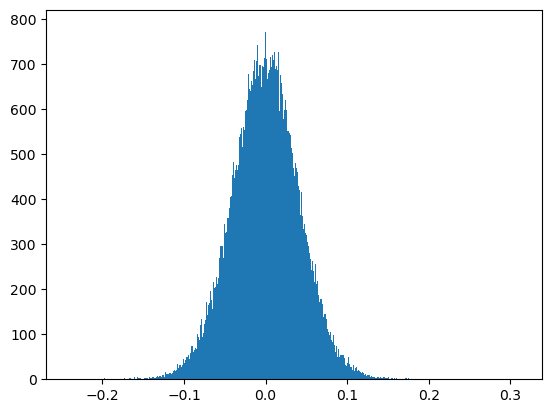

In [71]:
plt.hist((torch.tensor(favor_output, dtype=torch.float32) - regular_attention_output).reshape(-1), bins=1000);

In [14]:
import numpy as np
import matplotlib.pyplot as plt


# Vanila Transformer attention implementation
def att(q, k, v, normalize=True):
    l, d = q.shape
    normalizer = 1 / (d ** 0.5) if normalize else 1
    a = np.exp(q @ k.T * normalizer)
    d_inv = np.diag(1 / (a @ np.ones(l)))
    return d_inv @ a @ v


# Perfomer attention implementation using some random feature map phi
def att_hat(q, k, v, phi, normalize=True):
    l, d = q.shape
    normalizer = 1 / (d ** 0.25)
    q_prime = phi(q * normalizer)
    k_prime = phi(k * normalizer)
    d_inv = np.diag(1 / (q_prime @ (k_prime.T @ np.ones(l))))
    return d_inv @ (q_prime @ (k_prime.T @ v))


# random feature map
def phi(h, fs, random_feats):
    return lambda x: (
        h(x)
        / np.sqrt(m)
        * np.concatenate(
            [f(np.einsum("...d,md->...m", x, random_feats)) for f in fs],
            axis=-1,
        )
    )

# Performer "positive" attention
def positive_att_hat(q, k, v, random_feats, normalize=True):
    def h(x):
        return np.exp(-np.square(x).sum(axis=-1, keepdims=True) / 2)

    kernel = phi(h, [np.exp], random_feats)
    return att_hat(q, k, v, kernel, normalize)


# generate IID Gaussian random features
def iid_gaussian(m, d):
    return np.random.normal(size=(m, d))


# generate orthogonal Gaussian random features
def orthogonal_gaussian(m, d):
    def orthogonal_square():
        # create orthogonal square matrix using Gram-Schmidt
        q, _ = np.linalg.qr(iid_gaussian(d, d))
        return q.T

    num_squares = int(m / d)
    blocks = [orthogonal_square() for _ in range(num_squares)]

    remainder = m - d * num_squares
    if remainder:
        blocks.append(orthogonal_square()[:remainder])

    matrix = np.vstack(blocks)
    matrix /= np.sqrt(num_squares + remainder / d)

    return matrix


# mean squared error
def mse(a, b):
    return np.square(a - b).mean()
